# Лабораторная работа №3 
## Выполнил Буканов Никита ПМ-21М
## Вариант 2

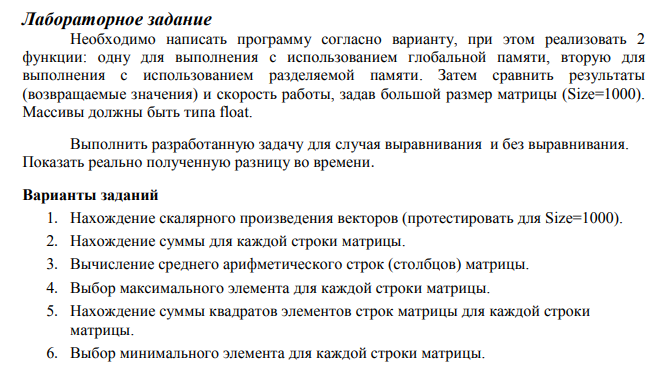

```c++
#include <cstdio>
#include <iostream>
#include <chrono>

constexpr size_t SIZE = 16384 * 3;
constexpr size_t BLOCK_COUNT = 4096;
constexpr size_t BLOCK_SIZE = SIZE / BLOCK_COUNT;
constexpr size_t THREAD_PER_BLOCK = 128;


// Функция выполняющая непосредственно расчеты
template<typename T>
__global__ void sumMatrixRowSharedOpt(T* matrix, T* result)
{
  __shared__ float data[THREAD_PER_BLOCK];
  
  for(size_t row_num = BLOCK_SIZE * blockIdx.x;
             row_num < BLOCK_SIZE * (blockIdx.x + 1); row_num++) {
    
    size_t row_start = row_num * SIZE;
    size_t idx = threadIdx.x;
    
    data[idx] = matrix[row_start + idx];
    
    for (size_t i=1; i * THREAD_PER_BLOCK + idx < SIZE; i++)
    {
      data[idx] = data[idx] + matrix[row_start + i * THREAD_PER_BLOCK + idx];
    }
    
    __syncthreads();
    
    for (size_t s = blockDim.x / 2; s > 0; s/=2)
    {
      if (idx < s)
      {
        data [idx] += data [idx + s];
      }
      __syncthreads();
    }
    
    if (idx == 0)
      result[row_num] = data[0];
  }
}

template <typename T>
void sumMatrixRowCPU(const float* matrix, T* result)
{
  for(int idx = 0; idx < SIZE; idx++)
  {
    result[idx] = 0;
    
    for(size_t i=0; i < SIZE; i++)
    {
      result[idx] = result[idx] + matrix[idx * SIZE + i];
    }
  }
}

__host__ int main()
{
  auto* matrix = new float[SIZE * SIZE];
  auto* result = new float[SIZE];
  auto* result_1 = new float[SIZE];
  
  for (int i = 0; i < SIZE * SIZE; i++)
  {
    matrix[i] = int(i/SIZE);
    result[i%SIZE] = 0;
    result_1[i%SIZE] = 0;
  }

  float* gpu_matrix;
  float* gpu_result;

  cudaMalloc((void**)&gpu_matrix, sizeof(float) * SIZE * SIZE);
  cudaMemcpy(gpu_matrix, matrix, sizeof(float) * SIZE * SIZE, cudaMemcpyHostToDevice);
  
  cudaMalloc((void**)&gpu_result, sizeof(float) * SIZE);
  cudaMemcpy(gpu_result, result, sizeof(float) * SIZE, cudaMemcpyHostToDevice);

  dim3 gridSize = dim3(BLOCK_COUNT, 1, 1);
  dim3 blockSize = dim3(THREAD_PER_BLOCK, 1, 1);
  
  cudaEvent_t kernel_start;
  cudaEventCreate(&kernel_start);
  cudaEventRecord(kernel_start, nullptr);

  sumMatrixRowSharedOpt<<<gridSize, blockSize>>>(gpu_matrix, gpu_result);

  cudaEvent_t syncEvent;
  cudaEventCreate(&syncEvent);
  cudaEventRecord(syncEvent, nullptr);
  cudaEventSynchronize(syncEvent);
  
  float time;
  cudaEventElapsedTime(&time, kernel_start, syncEvent);

  cudaMemcpy(result, gpu_result, sizeof(float) * SIZE, cudaMemcpyDeviceToHost);

  std::cout << "GPU Elapsed time " << time << std::endl;

  auto t1 = std::chrono::high_resolution_clock::now();
  sumMatrixRowCPU(matrix, result_1);
  auto t2 = std::chrono::high_resolution_clock::now();

  std::cout << "CPU Elapsed time " << std::chrono::duration_cast<std::chrono::milliseconds>(t2 - t1).count() <<std::endl;

  for (int i = 0; i < 10; i++)
  {
    printf("Element #%i: %.1f %1.f\n", i , result[i], result_1[i]);
  }


  // Освобождаем ресурсы
  cudaEventDestroy(syncEvent);
  cudaFree(gpu_matrix);
  cudaFree(gpu_result);
  delete[] result;
  delete[] result_1;
  delete[] matrix;
}
```

In [3]:
! ../cmake-build-debug/lab3_2

GPU Elapsed time 23.9342
CPU Elapsed time 6752
Element #0: 0.0 0
Element #1: 49152.0 49152
Element #2: 98304.0 98304
Element #3: 147456.0 147456
Element #4: 196608.0 196608
Element #5: 245760.0 245760
Element #6: 294912.0 294912
Element #7: 344064.0 344064
Element #8: 393216.0 393216
Element #9: 442368.0 442368


Для выбранного подхода выравнивание памяти не актуально (т.к доступ линейный), однако можно посмотреть как изменится производительность если использовать схему чтения из глобальной памяти приводящую к конфликту по банкам памяти

```c++
template<typename T>
__global__ void sumMatrixRowShared(T* matrix, T* result)
{
  __shared__ float data[THREAD_PER_BLOCK];
  for(size_t row_num = BLOCK_SIZE * blockIdx.x;
      row_num < BLOCK_SIZE * (blockIdx.x + 1); row_num++) {
    size_t row_start = row_num * SIZE;
    size_t idx = threadIdx.x;
    data[idx] = matrix[row_start + idx];
    for (size_t i=1; i * THREAD_PER_BLOCK + idx < SIZE; i++)
    {
      data[idx] = data[idx] + matrix[row_start + i * THREAD_PER_BLOCK + idx];
    }
    __syncthreads();
    for (size_t s = 1; s < blockDim.x; s <<= 1 )
    {
      size_t index = 2 * s * idx;
      if ( index < blockDim.x )
        data [index] += data [index + s];
      __syncthreads ();
    }

    if (idx == 0)
      result[row_num] = data[0];
  }
}
```

In [7]:
! ../cmake-build-debug/lab3_3

GPU Elapsed time 25.0761
CPU Elapsed time 6762
Element #0: 0.0 0
Element #1: 49152.0 49152
Element #2: 98304.0 98304
Element #3: 147456.0 147456
Element #4: 196608.0 196608
Element #5: 245760.0 245760
Element #6: 294912.0 294912
Element #7: 344064.0 344064
Element #8: 393216.0 393216
Element #9: 442368.0 442368


Полученная разница в результатах не значительна, (при усреднении по нескольким прогонам получается 23.9(без конфликтов) и 24.8(с конфликтами) миллисекунд.  
Это вызвано вычислительной простотой решаемой задачи, а так же большим используемым объемом общей памяти (48КB).  
Если снизить объем общей памяти разница становится более заметной, однако и общая производительность падает.  
После оптимизации алгоритма преимущество над 1 потоком CPU выросло с 10 до 30 раз. 